# Week of 2025.05.12 


## TODO 
- [ ] Atmosphere model
    - [x] Add lighthill tensor calculation and understand what is taking place. 
    - [x] Read over Eric's paper and better understand. 
    - [x] Implement a solution first as a volume integral
    - [ ] Think up how we would validate a solution like this. 
        - [ ] Eric suggests gaussian source term (with time), spatially uniform
    - [ ] Then implement the more efficient surface integral. Figure out what this looks like. 

- [x] Inspect steady state solution, try to better understand discrepancy. Results are in [this notebook](https://paxtonsc.github.io/files/geophysics/volcano_project/steady_state.html)


## Questions 
1. Given that the stress tensor seems to be defined for the whole domain, how we constrain our calculations to only take into account the smaller domain around the vent? 
2. Clarify with Mario, what exact output is he taking from the steady state solution? Is it just a single p0 value? If it is more than that, what does that data flow look like? 

## 0.0 Review eruption

In [199]:
%load_ext autoreload
%autoreload 2

from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

folder_name = "simple_eruption_model"
file_name = "tungurahua_rad_5_v25_conduit"
iterations = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iterations, viscosity_index=1, wall_friction_index=5, max_velocity=100, max_slip=60, max_tau=0.1, max_pressure=50, max_speed_of_sound=2000, max_water=20, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=1)

HTML(ani.to_html5_video())

## 1.0 Observed infrasound data

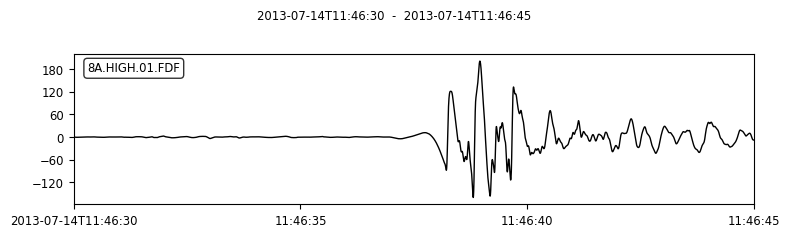

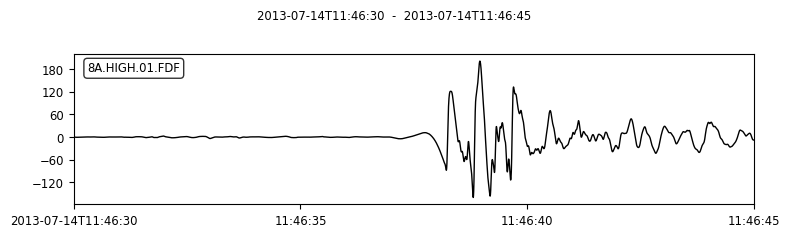

In [12]:
import matplotlib.pyplot as plt
import numpy as np

import obspy
from obspy import read, Stream, UTCDateTime
from obspy.io.mseed.util import get_record_information

file_path = "/Users/paxton/git/volcano_sims/infrasound_data/8A.HIGH.2013-07-14.mseed"

st = read(file_path)

tr0 = st[0]
tr0_filtered = tr0.copy()

freqmin = 1
freqmax = 20
tr0_filtered.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)

tr0_filtered.data = tr0_filtered.data * 1.589e-6 /  23e-6

t1 = UTCDateTime("2013-07-14T11:46:30")
t2 = UTCDateTime("2013-07-14T11:46:45")

tr0_filtered.trim(t1, t2)

tr0_filtered.plot()

## 2.0 monopole source simulation

The downside of the atmospheric coupling in quail is that the model is complicated and I don't fully understand it. As a small project, I am going to create a simple numerical solution for atmosphere based on treating the volcano as a monopole acoustic source where the pressure wave is a function purely of the ejected volume, which we consider to be incompressible. 

Eric shared [notes](https://drive.google.com/file/d/1khrmHWfoOqrcBjE533TtZirvnp9IIAc3/view?usp=sharing) on 3D acoustics, from which I will use the relation 

$$
p(r,t) = \frac{\rho \dot{Q}(t-r/c)}{4 \pi r * (2/3)}
$$

See more in-depth notes in my notes from [last week](https://paxtonsc.github.io/files/geophysics/volcano_project/2025.05.05.experiments.html).

The monopole source produces unfiltered infrasound waves to the correct order of magnitude (~200 Pa) but not sufficiently precise to match the specific observed wave pattern. 

In [2]:
solver_func = get_local_solver_from_index_func(folder_name, file_name)

u_vec = []
t_vec = []
R = 50 # m

for i in range(0, int(iterations), 1):
    solver = solver_func(i)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)

    # Define velocity as momentum divided by density. "velocity" when computed as an additional state variable appears to be an absolute value. 
    u = momentum.ravel() / rho.ravel()

    # Take only the exit velocity
    u_vec.append(np.maximum(u[-1], 0))
    t_vec.append(solver.time)

a_vec = np.gradient(np.array(u_vec), np.array(t_vec))
Q_dot_vec = np.pi * R**2 * a_vec # m^3/s^2

N = 100
pressure_array = np.zeros((N, N))
x_low, x_upper = -500, 3000
y_low, y_upper = -1000, 2500

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array, extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1500)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t):
    for i in range(N):
        for j in range(N):
            x = x_low + (x_upper - x_low) * i / N
            y = y_low + (y_upper - y_low) * j / N

            if infrasound.point_in_volcano(x, y):
                pressure_array[j][i] = 0  # Set pressure to 0 inside volcano
            else:
                pressure_array[j][i] = infrasound.relative_pressure(t, x, y, t_vec, Q_dot_vec)

    im.set_array(pressure_array)
    ax.set_title(f'Pressure Distribution at t={t:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=np.asarray(t_vec[0:int(iterations)]), 
                    interval=200, blit=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

Text(0.02, 0.5, 'Pressure (Pa)')

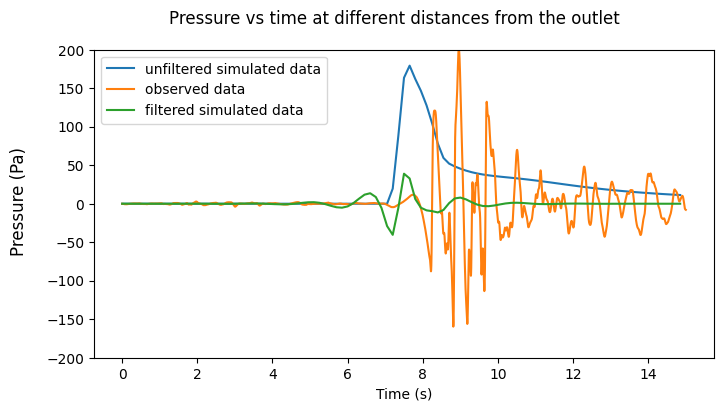

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax.plot(t_vec, pressure_at_2000, label="unfiltered simulated data")
ax.plot(tr0_filtered.times(), tr0_filtered.data, label="observed data")
ax.plot(t_vec, p_relative_arr_2000_filtered, label="filtered simulated data")

ax.set_ylim(-200, 200)
ax.legend()
ax.set_xlabel("Time (s)")

fig.suptitle("Pressure vs time at different distances from the outlet")
fig.supylabel("Pressure (Pa)")

## 3.0 Review quail atmosphere model

Let's look at our model where we set the pressure to be constant and remove the gravity term. 

In [190]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 100

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("simple_eruption_model", "test_infrasound_v27_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e3, 1e3)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1 - p1_0, clims)
    plt.title(f"Pressure Field at Sec {round(10/15 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

In [ ]:
import matplotlib.tri as tri

# Assume solver2D_from is available as in the original code
solver2D_1 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm1")
solver2D_2 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm2")
solver2D_3 = get_local_solver_from_index_func("eruption_model", "test_infrasound_v26_atm3") 


triangulation1 = tri.Triangulation(solver2D_1(0).mesh.node_coords[...,0],
                  solver2D_1(0).mesh.node_coords[...,1], 
                  triangles=solver2D_1(0).mesh.elem_to_node_IDs)

triangulation2 = tri.Triangulation(solver2D_2(0).mesh.node_coords[...,0],
                  solver2D_2(0).mesh.node_coords[...,1], 
                  triangles=solver2D_2(0).mesh.elem_to_node_IDs)

triangulation3 = tri.Triangulation(solver2D_3(0).mesh.node_coords[...,0],
                  solver2D_3(0).mesh.node_coords[...,1], 
                  triangles=solver2D_3(0).mesh.elem_to_node_IDs)
                  
trifinder1 = triangulation1.get_trifinder()
trifinder2 = triangulation2.get_trifinder()
trifinder3 = triangulation3.get_trifinder()

trifinders = [trifinder1, trifinder2, trifinder3]

p_relative_arr_200 = infrasound.get_p_series(200, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_500 = infrasound.get_p_series(500, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_1500 = infrasound.get_p_series(1500, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)
p_relative_arr_2000 = infrasound.get_p_series(2000, 0, solver2D_1, solver2D_2, solver2D_3, trifinders)

Element ID for point (200, 0): 92
Element ID for point (500, 0): 714
Element ID for point (1500, 0): 785
Element ID for point (2000, 0): 960


In [6]:
from scipy import signal

fs = 10  # Sampling frequency (Hz)

# Step 2: Define band-pass filter parameters
lowcut = 1.0  # Lower cutoff frequency (Hz)
order = 5  # Filter order

# Normalize cutoff frequencies to Nyquist frequency (fs/2)
nyquist = 0.5 * fs
low = lowcut / nyquist

# Step 3: Design Butterworth band-pass filter
b, a = signal.butter(order, low, btype='high')

p_relative_arr_200_filtered = signal.filtfilt(b, a, p_relative_arr_200)
p_relative_arr_500_filtered = signal.filtfilt(b, a, p_relative_arr_500)
p_relative_arr_1500_filtered = signal.filtfilt(b, a, p_relative_arr_1500)
p_relative_arr_2000_filtered = signal.filtfilt(b, a, p_relative_arr_2000)

Text(0.5, 0.98, 'Pressure Time Series at Different Distances from the outlet (after filtering out anything below 1 Hz)')

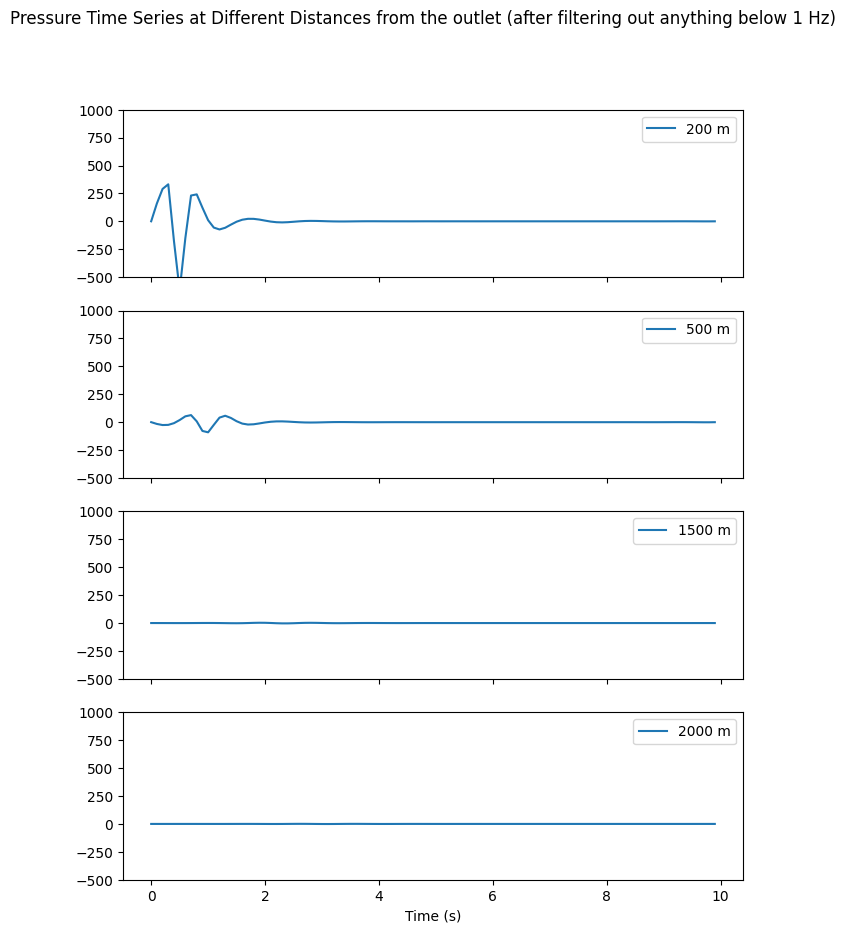

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_200_filtered, label="200 m")
axes[1].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_500_filtered, label="500 m")
axes[2].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_1500_filtered, label="1500 m")
axes[3].plot(np.arange(0, iterations*(1/10), 1/10), p_relative_arr_2000_filtered, label="2000 m")

for ax in axes:
    ax.set_ylim(-5e2, 1e3)
    ax.legend()
    
plt.xlabel("Time (s)")
fig.suptitle("Pressure Time Series at Different Distances from the outlet (after filtering out anything below 1 Hz)")

## 5.0 Lighthill accostic analogy theory

From Eric: 

> If we wanted to get really ambitious, then what we could do is implement the Lighthill acoustic analogy theory. See section 3.6.2 in Fred's thesis, specifically equations (3.129) and (3.130). Fred has code to calculate the Lighthill stress tensor, which is a source term. We would then take that source term and convolve it with the linear acoustics Green's function. In fact, that could later be replaced with a fully coupled acoustic-elastic Green's function from another code (SPECFEM) that Mario has used. There are many reasons to do this: first, it only requires using Fred's code to get the flow field around the vent correctly, and it doesn't matter if there is too much damping in the numerics to accurately model acoustic propagation beyond a few hundred meters. Second, we know that the ground is not rigid, but elastic, as Fred's code assumes. The acoustic-elastic Green's functions will allow us to use all parts of the seismograms (right now we ignore the displacements caused by the strong infrasound blast). Mario and I have discussed this as a possible extension of his work.

### Notes on Lighthill Accoustic Analogy,  [Fred's thesis ](https://drive.google.com/drive/folders/1xwnqopoice-zy-8HfxhxLIeNJFAgZX5L) section 3.6.2

- Fred models 2150m conduit with 50m radius 
- Model the top 150m of the conduit as part of a axissymmetric 2d domain. 

Interestingly, Fred was able to get his model to create a burst of pressure of the right order of magnitude for the Tungurahua eruption:

> In comparison, our model prediction for
a sensor placed at a similar location on the flank 2 km from the vent produces a pressure peak of
a similar duration and order of magnitude as the Tungurahua Vulcanian blast, despite not having
tuned our parameters to fit the Tungurahua eruption.

Light hill's acoustic analogy is established by manipulating the governing equation for compresable flow to obtain 

$$
\frac{1}{a_0^2} \frac{\partial^2p}{\partial t^2} - \nabla^2 p = \nabla \cdot (\nabla \cdot \bf{T})
$$

where $a_0$ is the speed of sound in the atmosphere and $\bf{T}$ is the Lighthill stres sensor. 

The inviscid Lighthill stress tensor comprises a convective term plus another nonlinear term.

$$
\bf{T} = \rho \bf{u} \otimes \bf{u} + (p - a_0^2 \rho) \bf{I}
$$

Note:

$\rho u_i u_j$ - Reynolds stress 

$p - a_0^2 \rho$ - Thermodynamic pressure term. 


### Notes from talking with Eric 05/07

**1. Define the source**

$$ \frac{1}{c_0^2} \frac{\partial^2p}{\partial t^2} - \nabla^2 p = S(\bf{x}, t) $$

**2. Compute Green's function**

First, let's review what a [Green's function](https://en.wikipedia.org/wiki/Green%27s_function) is. A Green's function allows us to rewrite the problem as a sum of source points.

$$ 
\frac{1}{c_0^2} \frac{\partial^2 G(\bf(x), \bf(y), t)}{\partial t^2} + \nabla^2 G = \delta^{(3)}(\bf{x} - \bf{y})\delta(t)
$$

The Green's function, written for all space looks something like

$$
G(\bf{x}, \bf{y}, t) = \frac{\delta(t - \frac{|\bf{x} - \bf{y}|}{c_0})}{4 \pi | \bf{x} - \bf{y}|}
$$
 
So the pressure at any given point can be expressed as 

$$
p(\bf{x}, t) = \int \int_V G(\bf{x}, \bf{y}, t-\tau) S(\bf{y}, \tau) d^3y d \tau
$$



**3. How do we evaluate the convolution numerically.**

We would probably work in the frequency domain. Tends to be easier. So

$$
p(\bf{x}, \omega) = \int_V G(\bf{x}, \bf{y}, \omega) S(\bf{y}, \tau) d^3y d
$$


### Notes from [paper](https://drive.google.com/file/d/18dS_SlExCoOoAUUXYuxTV1Gkl9PyO_4f/view?usp=sharing) that Eric and Leighton worked on

In this paper Eric shows that general equation for pressure can be simplified when you assume liner wave propagation (which reduces the lighthill stress tensor to zero):

$$
\Delta p (x, t) = \frac{1}{4 \pi} (\frac{\partial}{\partial t} \int_s [\frac{\rho v \cdot n}{r}]dS - \frac{\partial}{\partial x_j} \int_S n_i [\frac{p_{ij}}{r}]dS)
$$


Which in turn can be expressed in the frequency domain as:

$$
\Delta \hat{p} (x, \omega) = \frac{1}{4 \pi} i \omega \int_S \frac{\hat{p}\hat{v_n}}{|x - x'|} \exp(- i \omega \frac{|x - x'|}{c}) dS - \frac{1}{4 \pi} \int_S \frac{\hat{p} n_i}{|x - x'|^2} ( \frac{- i \omega (x_i - x_i')}{c} + \frac{x_i - x_i'}{|x - x'|}) \exp( - i \omega \frac{|x - x'|}{c}) dS 
$$



**Does this imply that I should experiment with the monopole and dipole source, but without populating a lighthill stress tensor?**


### 5.1 Calculating light hill stress tensor 


In [191]:
import helper_code.lighthill as lighthill
import numpy as np
import matplotlib.tri as tri

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("simple_eruption_model", f"test_infrasound_v27_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 500, 200)
base_y = np.linspace(-200, 1000, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1,2,3]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,iterations,1)

In [192]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, file_idx) for dom_idx in [1,2,3]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

In [193]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))


t_range = np.linspace(0, 20, T_interp.shape[0])

In [194]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

In [203]:
# Grid dimensions
dx = np.diff(mg_x[0:1,:], axis=1)
dy = np.diff(mg_y[:,0:1], axis=0)
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]

# Grid-center differentiation
u_foldx = (0.5 * (mg_u[:,:,1:] + mg_u[:,:,:-1]))
u_foldy = (0.5 * (mg_u[:,1:,:] + mg_u[:,:-1,:]))
dudy = np.diff(u_foldx, axis=1) / dy
dudx = np.diff(u_foldy, axis=2) / dx

v_foldx = (0.5 * (mg_v[:,:,1:] + mg_v[:,:,:-1]))
v_foldy = (0.5 * (mg_v[:,1:,:] + mg_v[:,:-1,:]))
dvdy = np.diff(v_foldx, axis=1) / dy
dvdx = np.diff(v_foldy, axis=2) / dx

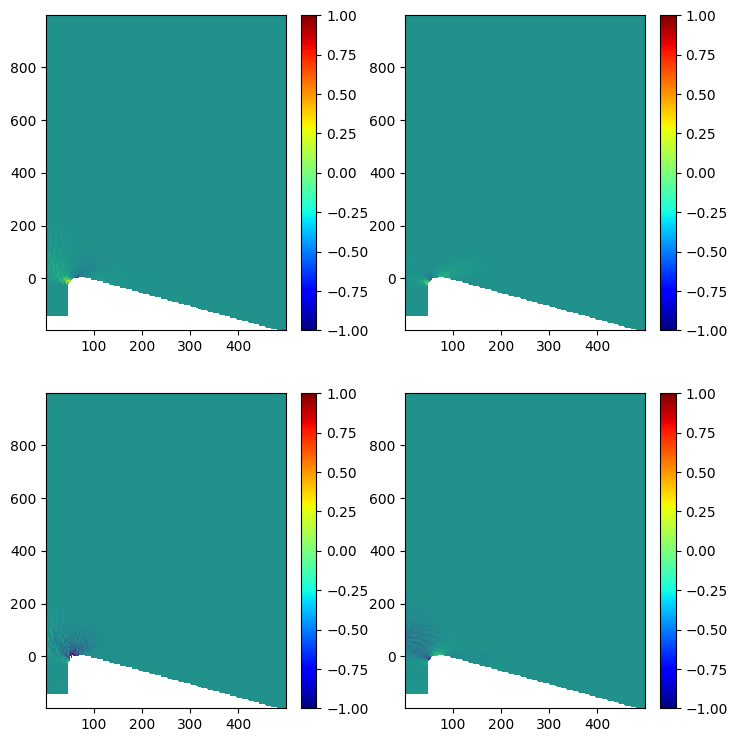

In [204]:
import matplotlib 

time_idx = 30
fig, ax = plt.subplots(2,2,figsize=(8.5,9))

global_clims = (-5, 5)
levels = np.linspace(-1, 1, 100)

cf = ax[0,0].contourf(center_x, center_y, dudx[time_idx,:,:], levels=levels)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=cf.get_clim()[0], vmax=cf.get_clim()[1]),
  cmap=matplotlib.cm.jet)
cb = plt.colorbar(sm, ax=ax[0,0])

cf = ax[0,1].contourf(center_x, center_y, dudy[time_idx,:,:], levels=levels)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=cf.get_clim()[0], vmax=cf.get_clim()[1]),
  cmap=matplotlib.cm.jet)
cb = plt.colorbar(sm, ax=ax[0,1])

cf = ax[1,0].contourf(center_x, center_y, dvdx[time_idx,:,:], levels=levels)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=cf.get_clim()[0], vmax=cf.get_clim()[1]),
  cmap=matplotlib.cm.jet)
cb = plt.colorbar(sm, ax=ax[1,0])

cf = ax[1,1].contourf(center_x, center_y, dvdy[time_idx,:,:], levels=levels)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=cf.get_clim()[0], vmax=cf.get_clim()[1]),
  cmap=matplotlib.cm.jet)
cb = plt.colorbar(sm, ax=ax[1,1])

In [205]:
mg_c0 = mg_c[0,...]
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]
# Interior grid-center coordinates
int_x = center_x[1:-1,1:-1]
int_y = center_y[1:-1,1:-1]

In [206]:
# Evaluate matrix T
T00_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho
T01_nonlinear = np.zeros_like(mg_rho)
T10_nonlinear = np.zeros_like(mg_rho)
T11_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho

In [207]:
Nt, Nx, Ny = mg_p.shape

# Central differences using np.diff (second difference)
d_p_dx0 = np.diff(mg_p, n=2, axis=1) / (2 * dx[0, 0])
d_p_dx1 = np.diff(mg_p, n=2, axis=2) / (2 * dy[0, 0])
d_rho_dx0 = np.diff(mg_rho, n=2, axis=1) / (2 * dx[0, 0])
d_rho_dx1 = np.diff(mg_rho, n=2, axis=2) / (2 * dy[0, 0])
    
# Pad arrays to restore original shape (Nx, Ny)
diTij_nonlinear = np.zeros((2, Nt, Nx, Ny))

d_c0_dx0 = np.diff(mg_c0, n=2, axis=0) / (2 * dx[0, 0])
d_c0_dx1 = np.diff(mg_c0, n=2, axis=1) / (2 * dy[0, 0])
diTij_nonlinear[0, :, 1:-1, :] = d_p_dx0 - mg_c0[1:-1, :]**2 * d_rho_dx0 - 2 * mg_c0[1:-1, :] * mg_rho[:, 1:-1, :] * d_c0_dx0
diTij_nonlinear[1, :, :, 1:-1] = d_p_dx1 - mg_c0[:, 1:-1]**2 * d_rho_dx1 - 2 * mg_c0[:, 1:-1] * mg_rho[:, :, 1:-1] * d_c0_dx1


diTij_nonlinear.shape


(2, 100, 200, 200)

In [208]:
# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_nonlinear, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_nonlinear[:,1:,:] + T00_nonlinear[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_nonlinear[:,:,1:] + T11_nonlinear[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

In [209]:
# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_nonlinear = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

In [210]:
# Evaluate matrix T
T00_inertial = mg_rho * mg_u * mg_u
T01_inertial = mg_rho * mg_u * mg_v
T10_inertial = mg_rho * mg_v * mg_u
T11_inertial = mg_rho * mg_v * mg_v

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_inertial, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_inertial[:,1:,:] + T00_inertial[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_inertial[:,:,1:] + T11_inertial[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_inertial = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

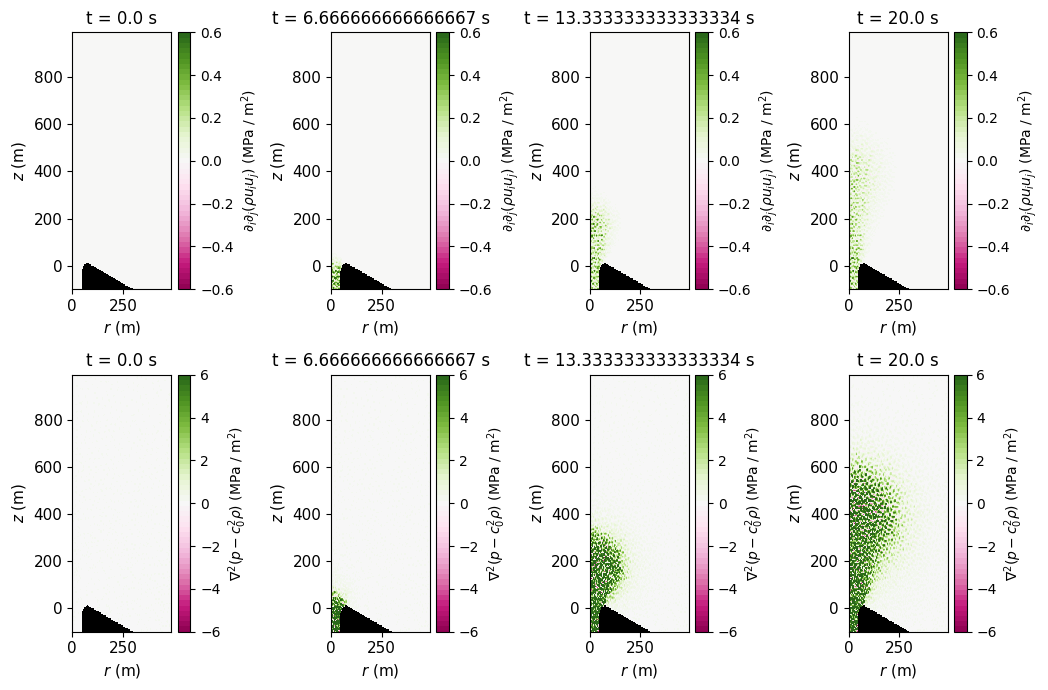

In [212]:
import matplotlib
fig, ax = plt.subplots(2, 4, figsize=(10.5,7))

levels = np.linspace(-.6e6, .6e6, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [0, 33, 66, 99]


for i, t_ind in enumerate(t_indices):
  ax[0,i].set_facecolor("black")
  cf = ax[0,i].contourf(int_x, int_y, np.clip(dijTij_inertial[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\partial_i \partial_j (\rho u_i u_j)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[0,i].set_xlim(0, 490)
  ax[0,i].set_ylim(-100, 990)
  #ax[0,i].set_aspect('equal')
  ax[0,i].set_xlabel("$r$ (m)")
  ax[0,i].set_ylabel("$z$ (m)")
  curr_ax = ax[0,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[0,i].set_title(f"t = {t_range[t_ind]} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

# fig.tight_layout()
  
# fig, ax = plt.subplots(1, 3, figsize=(8.5,3.5))

levels = np.linspace(-6e6, 6e6, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [0, 33, 66, 99]

for i, t_ind in enumerate(t_indices):
  ax[1,i].set_facecolor("black")
  cf = ax[1,i].contourf(int_x, int_y, np.clip(dijTij_nonlinear[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\nabla^2 (p - c_0^2 \rho)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[1,i].set_xlim(0, 490)
  ax[1,i].set_ylim(-100, 990)
  #ax[1,i].set_aspect('equal')
  ax[1,i].set_xlabel("$r$ (m)")
  ax[1,i].set_ylabel("$z$ (m)")
  curr_ax = ax[1,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[1,i].set_title(f"t = {t_range[t_ind]} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

fig.tight_layout()
plt.draw()

As a quick sanity check, let's just plot the sum of the two terms that make up the lighthill stress tensor. 

### Plot divergence of lighthill stress tensor

In [215]:
clims = [-5e6, 5e6]

fig, ax = plt.subplots(1, 2)

img = ax[0].imshow(diTij_nonlinear[0,0], aspect='auto', vmin=clims[0], vmax=clims[1], extent=[int_x[0,0], int_x[0,-1], int_y[-1,0], int_y[0, 0]], cmap=matplotlib.cm.PiYG)
img2 = ax[1].imshow(diTij_nonlinear[1,0], aspect='auto', vmin=clims[0], vmax=clims[1], extent=[int_x[0,0], int_x[0,-1], int_y[-1,0], int_y[0, 0]], cmap=matplotlib.cm.PiYG)

plt.colorbar(img)
plt.colorbar(img2)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.6)
plt.suptitle("Divergence of Lighthill Tensor")

ax[0].set_title('x component')
ax[0].set_ylabel('height (m)')
ax[0].invert_yaxis()

ax[1].set_title('y component')
ax[1].set_xlabel('radius (m)')
ax[1].invert_yaxis()


# Update function for animation
def update(i):
    img.set_array(diTij_nonlinear[0,i])
    img2.set_array(diTij_nonlinear[1,i])
    return [img, img2]

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(len(t_range)), 
                    interval=50, blit=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

## 5.2 Solving a volume integral to calculate the acoustic pressure at the observer location (2000,0)

Some notes, I am calculating the volume integral over the half-cylindrical region bounded by $r < 400$ and $y > -100$ and $y<500$. 

As we can see in the above graphics, the value of the double divergence of the  lighthill stress tensor falls off outside those bounds. 

The equation we solve below is:

$$
p'(x,t) = \frac{1}{4\pi} \int_v \frac{1}{|x - y|} \frac{\partial^2 T_{ij}}{\partial y_i \partial y_j} (y, t - \frac{|x-y|}{c_0}) dy^3
$$

To solve for pressure as a time series, we can just iterate over the integral for all time steps. We need only calculate the value of $\frac{\partial^2 T_{ij}}{\partial y_i \partial y_j}$ when $t - \frac{|x-y|}{c_0}$ is greater than 0 and less than the end of the simulation. 

- [ ] The $4 \pi$ in the denominator is technically incorrect for our geometry. 
- [ ] Once I feel confident about the soundness of my code, I should decrease the mesh size and time sampling size to get a more precise result. 

In [ ]:
from scipy.interpolate import RegularGridInterpolator

def calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source, t_range, max_r, c0):
    dv = (X[1] - X[0]) * (Y[1] - Y[0]) * (Z[1] - Z[0])

    print(f"DV size is {dv}")

    rs = []
    src_values = []
    p_t = np.zeros(len(file_index_list))

    for t_idx in file_index_list:
        for i in range(len(X)):
            for  j in range(len(Y)):
                for k in range(len(Z)):
                    # source position
                    y_src = np.array([X[i], Y[j], Z[k]])

                    # distance from source to observation point
                    r = np.linalg.norm(x_obs - y_src)
                    t_ret = t_range[t_idx] - r / c0

                    # a little hacky, but ignore any contributions with r the max value of Y
                    if np.linalg.norm([X[i], Z[k]]) > max_r:
                        continue

                    # For the moment let's skip summing values inside the conduit. 
                    if Y[k] < 0:
                        continue

                    if t_ret >= 0 and t_ret < t_range[-1]:
                        interpolator = RegularGridInterpolator(points, source, method='linear', bounds_error=False, fill_value=0)

                        src_val = interpolator([t_ret, Y[j], np.linalg.norm([X[i], Z[k]])])

                        if not np.isnan(src_val):
                            p_t[t_idx] += (src_val / (4 * np.pi * r) ) * dv
                            rs.append(r)
                            src_values.append(src_val)

        if t_idx % 10 == 0:
            print(f"Finished time index {t_idx} of {len(file_index_list)}")

    print(f"Number of contributions: {len(rs)}") 
    print(f"r average: {np.average(rs)}")
    print(f"Max source value: {max(np.asarray(src_values))}")
    return p_t

In [80]:


source = dijTij_inertial + dijTij_nonlinear
x_obs = (2000, -1000, 0)
c0 = 320 # m/s roughly the speed of sound in air at 5000m in elevation
atmosphere_solid_angle = 4 * np.pi * (2/3)

X = int_x[0]
Y = int_y[:,0]

X = np.linspace(-200, 200, 20)
Y = np.linspace(0, 400, 20)
Z = np.linspace(-200, 200, 20)

points = (t_range, int_y[:,0], int_x[0])

pressure_obs = calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source, t_range, int_x[0][-1])

DV size is 9330.806239976675
Finished time index 0 of 87
Finished time index 10 of 87
Finished time index 20 of 87
Finished time index 30 of 87


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_2701/3169800005.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_t[t_idx] += (src_val / (4 * np.pi * r) ) * dv


Finished time index 40 of 87
Finished time index 50 of 87
Finished time index 60 of 87
Finished time index 70 of 87
Finished time index 80 of 87
Number of contributions: 362070
r average: 2333.9973663390324
Max source value: [81100367.03031133]


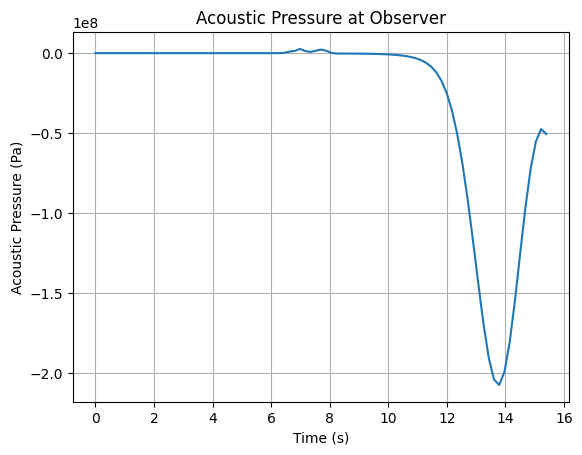

In [81]:
# Plot acoustic pressure
plt.plot(t_range, pressure_obs)
plt.xlabel('Time (s)')
plt.ylabel('Acoustic Pressure (Pa)')
plt.title('Acoustic Pressure at Observer')
plt.grid(True)
plt.show()

Now, if we pass that pressure wave through a high-pass filter to remove out the signal <1 Hz we get the following. 

In [155]:
from scipy import signal

def highpass(p, lowcut=1.0):
    fs = 10  # Sampling frequency (Hz)

    # Step 2: Define band-pass filter parameters
    lowcut = 1.0  # Lower cutoff frequency (Hz)

    order = 5  # Filter order

    # Normalize cutoff frequencies to Nyquist frequency (fs/2)
    nyquist = 0.5 * fs
    low = lowcut / nyquist

    # Step 3: Design Butterworth band-pass filter
    b, a = signal.butter(order, low, btype='high')

    return signal.filtfilt(b, a, p)

Text(0.5, 1.0, 'Filtered Acoustic Pressure at Observer based on Lighthill analogy')

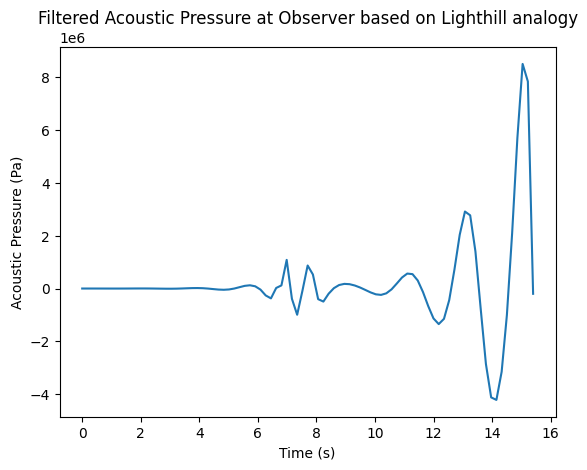

In [83]:
plt.plot(t_range, p_filtered)
plt.xlabel('Time (s)')
plt.ylabel('Acoustic Pressure (Pa)')
plt.title('Filtered Acoustic Pressure at Observer based on Lighthill analogy')

## 5.3 validate model with known source 

$$
G(\bf{x}, \bf{y}, t) = \frac{\delta(t - \frac{|\bf{x} - \bf{y}|}{c_0})}{4 \pi | \bf{x} - \bf{y}|}
$$
 
So the pressure at any given point can be expressed as 

$$
\begin{align}
p(\bf{x}, t) =& \int \int_V G(\bf{x}, \bf{y}, t - \tau) S(\bf{y}, \tau) d^3y d \tau \\

\end{align}
$$

In this case, because the source term is uniform across the volume $R < 100$ and $Y>0$ and $Y< 100$.

To find the max pressure we would expect, we write the equation:

$$
p_{max} = \frac{1}{4 \pi} \int_V \frac{1}{|x_{obs} - y|} dy 
$$

That can roughly be approximated as

$$
\begin{align}
p_{max} =& \frac{1}{4 \pi} \frac{V}{r_{avg}} \\
p_{max} =& \frac{1}{4 \pi} \frac{\pi * 100^2 * 200}{2300} \\
p_{max} =& 220 [Pa]
\end{align}
$$


In the below example, I show that numerically I arrive at a solution with a max pressure of about 190. 
 

In [217]:
n = len(t_range)  # Length of the vector
mu = n // 4  # Center of the pulse is 1/4 through the time series
sigma = 5  # Standard deviation (controls pulse width)

nx = len(int_x[0])
ny = len(int_y[:,0])

print(f"nx {nx} and ny {ny}")
# Create index array
x = np.arange(n)

# Compute Gaussian pulse
pulse = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

source_gaussian = np.zeros(dijTij_inertial.shape)

nan_mask = np.isnan(dijTij_inertial)

for i in range(nx):
    for j in range(ny):
        if int_y[j, 0] > 0 and int_y[j,0] < 200 and int_x[0,i] < 100:
            source_gaussian[:, j, i] = pulse

source_gaussian[nan_mask] = np.nan

clims = [-1, 1]

fig, ax = plt.subplots()

img = ax.imshow(source_gaussian[0], cmap=matplotlib.cm.PiYG, aspect='auto', vmin=clims[0], vmax=clims[1], extent=[int_x[0,0], int_x[0,-1], int_y[-1,0], int_y[0, 0]])
plt.gca().invert_yaxis()
plt.colorbar(img)
ax.set_title('Uniform Gaussian Pulse')
ax.set_xlabel('radius (m)')
ax.set_ylabel('height (m)')


# Update function for animation
def update(i):
    img.set_array(source_gaussian[i])
    return [img]

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(len(t_range)), 
                    interval=50, blit=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

nx 197 and ny 197


In [151]:
X = np.linspace(-200, 100, 20)
Y = np.linspace(0, 200, 20)
Z = np.linspace(-100, 100, 20)

points = (t_range, int_y[:,0], int_x[0])

pressure = calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source_gaussian, t_range, int_x[0][-1])

DV size is 1749.5261699956259
Finished time index 0 of 87
Finished time index 10 of 87
Finished time index 20 of 87
Finished time index 30 of 87


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_2701/3169800005.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_t[t_idx] += (src_val / (4 * np.pi * r) ) * dv


Finished time index 40 of 87
Finished time index 50 of 87
Finished time index 60 of 87
Finished time index 70 of 87
Finished time index 80 of 87
Number of contributions: 355920
r average: 2328.228649313091
Max source value: [0.999992116235219]


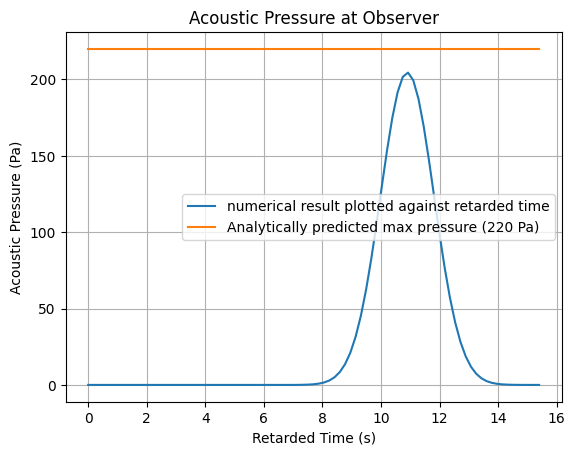

Max pressure 204.4826245941233


In [153]:
r_avg = 2300 #m
retarded_time = t_range - r_avg/c0

# Plot acoustic pressure
plt.plot(t_range, pressure, label="numerical result plotted against retarded time")
plt.plot(t_range, np.ones(t_range.shape)*220, label="Analytically predicted max pressure (220 Pa)")
plt.xlabel('Retarded Time (s)')
plt.ylabel('Acoustic Pressure (Pa)')
plt.title('Acoustic Pressure at Observer')
plt.grid(True)
plt.legend()
plt.show()

print(f"Max pressure {max(pressure)}")

## 5.4 Numerical solution as a surface integral rather than a volume integral 

Eric suggested I solved this problem as a surface integral. Doing so would allow us to remove one spatial dimension at the expense of slightly more complicated math. 

Previously, we had expressed the pressure as the following integral.

$$
\begin{align}
p'(x,t) = \frac{1}{4\pi} \int_v \frac{1}{|x - y|} \frac{\partial}{\partial y_i} \frac{\partial T_{ij}}{\partial y_j} (y, t - \frac{|x-y|}{c_0}) dy^3
\end{align}
$$

Applying the divergence theorm, we are able to rewrite this volume integral as a surface intgral. 


$$
\begin{align}
p'(x,t) = \frac{1}{4\pi} \int_S \frac{1}{|x - y|}  \frac{\partial T_{ij}}{\partial y_j} (y, t - \frac{|x-y|}{c_0}) \cdot \hat{n} dy^2
\end{align}
$$

Let's integrate over the sphere with a radius $a=100m$. Let's review a couple aspects of spherical coordinates. 

$$
\begin{align}
dS =& a^2 \sin \phi d \phi d \theta \\
x =& a \sin \phi \cos \theta \\
y =& a \sin \phi \sin \theta \\
z =& a \cos \phi
\end{align}
$$

So we should be able to rewrite the surface integral as follows: 

$$
p'(x, t) = \frac{1}{4 \pi} \int_0^{\pi/3} \int_0^{2\pi}  \frac{1}{|x - y|} \frac{\partial T_{ij}}{\partial y_j} n_j a^2 \sin \phi d \phi d \theta
$$

In [219]:
from scipy.interpolate import RegularGridInterpolator

def calculate_surface_integral(div_T, a, t_idx, t_range, x_obs, c0, points):
    N_theta, N_phi = 50, 50

    theta = np.linspace(0, np.pi/3, N_theta)
    phi = np.linspace(0, 2*np.pi, N_phi)
    a = 100 # [m]

    dphi = phi[1] - phi[0]
    dtheta = theta[1] - theta[0]

    p_t = 0

    for i in range(N_theta):
        for j in range(N_phi):
            ds = a**2 * np.sin(phi[j]) * dphi * dtheta
            x = a * np.sin(phi[j]) * np.cos(theta[i])
            y = a * np.sin(phi[j]) * np.sin(theta[i])
            z = a * np.cos(phi[j])

            r = np.linalg.norm(np.array([x, y, x]) - x_obs)

            t_ret = t_range[t_idx] - r / c0

            if t_ret > 0 and t_ret < t_range[-1]:

                interpolator = RegularGridInterpolator(points, div_T, method='linear', bounds_error=False, fill_value=0)

                src_val_0 = interpolator([0, t_ret, z, np.linalg.norm([x, y])])
                src_val_1 = interpolator([1, t_ret, z, np.linalg.norm([x, y])])

                if not np.isnan(src_val_0) and not np.isnan(src_val_1):
                    p_t += 1/a * (src_val_0*z + src_val_1*np.linalg.norm([x, y])) / (4 * np.pi * r) * ds
    
    return p_t

In [220]:
points = (range(2), t_range, mg_y[:,0], mg_x[0])

pressure = np.zeros(len(file_index_list))

for i, time_idx in enumerate(file_index_list):
    pressure[i] = calculate_surface_integral(diTij_nonlinear, 100, time_idx, t_range, x_obs, c0, points)

    if i % 10 == 0: 
        print(f"Completed step of index {i}")
    

Completed step of index 0
Completed step of index 10
Completed step of index 20
Completed step of index 30


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_2701/2335448470.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pressure[i] = calculate_surface_integral(diTij_nonlinear, 100, time_idx, t_range, x_obs, c0, points)


Completed step of index 40
Completed step of index 50
Completed step of index 60
Completed step of index 70
Completed step of index 80
Completed step of index 90


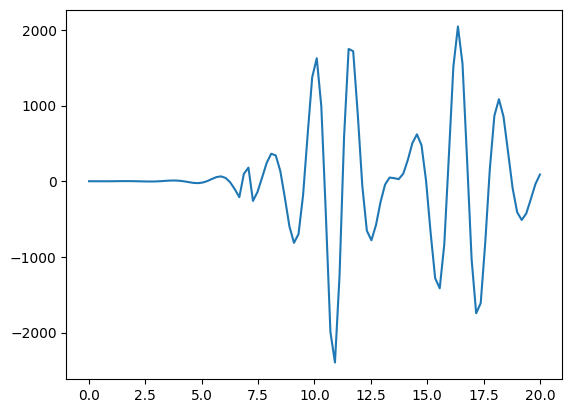

In [223]:
#plt.plot(t_range, pressure)
plt.plot(t_range, highpass(pressure))